In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from scipy import optimize

# 1

In [2]:
beta = lambda x, y: np.dot(np.dot(np.linalg.inv(x.T.dot(x)), x.T), y)
predict = lambda x, b: x.dot(b)

In [3]:
noisysine = pd.read_csv('../data/noisysine.csv')
hydrodynamics = pd.read_csv('../data/hydrodynamics.csv')

In [4]:
def plot_regression(x, y, b):
    plt.figure(figsize=(10, 5))
    plt.scatter(x[:, 1], y)
    x_axis = np.linspace(x[:, 1].min(), x[:, 1].max(), len(x))
    y = 0

    for i in range(len(b)):
        y += b[i] * x_axis ** i
        
    plt.plot(x_axis, y, color='red') 
    plt.show()

In [5]:
def regression(data, y, power, label='y', plot=False, b_ridge=False, verbose=False, lasso=False):
    for p in range(1, power + 1):
        pf = PolynomialFeatures(p)
        x = pf.fit_transform(data)
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
        if b_ridge:
            r, b = ridge(x_train, y_train, verbose=verbose)
            print(f'Ridge = {r}')
        elif lasso:
            lcv = LassoCV(cv=5, random_state=0).fit(x, y)
            b = lcv.coef_
            print(f'Использовано признаков {len(b[b != 0])} / {len(b)}')
        else:
            b = beta(x_train, y_train)
        
        print(f'R^2 для степени {p}')
        if lasso:
            y_pred = predict(x, b)
            print(f'\tВесь набор: {r2_score(y, y_pred):.3f}')
        else:
            y_pred = predict(x_test, b)
            print(f'\tвалидация: {r2_score(y_test, y_pred):.3f}')
            y_pred = predict(x_train, b)
            print(f'\tобучающий набор: {r2_score(y_train, y_pred):.3f}')

        if plot:
            plot_regression(x_test, y_test, b)

R^2 для степени 1
	валидация: -0.082
	обучающий набор: 0.113


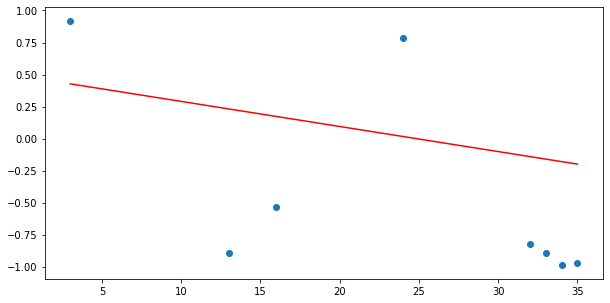

R^2 для степени 2
	валидация: 0.211
	обучающий набор: 0.163


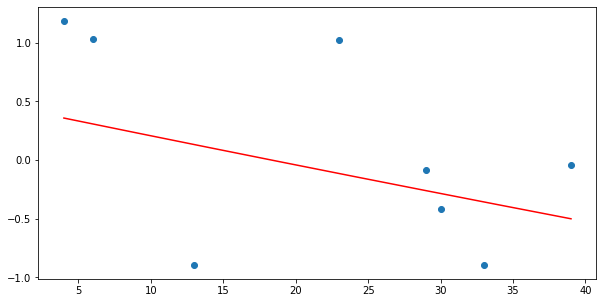

R^2 для степени 3
	валидация: 0.356
	обучающий набор: 0.279


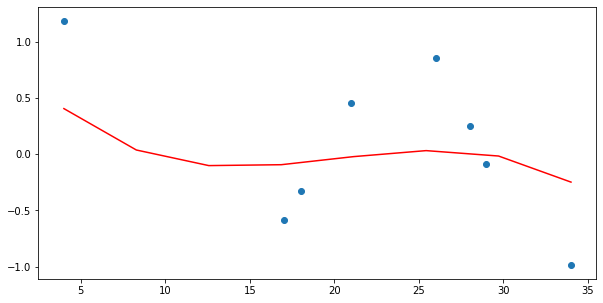

R^2 для степени 4
	валидация: -6.009
	обучающий набор: 0.579


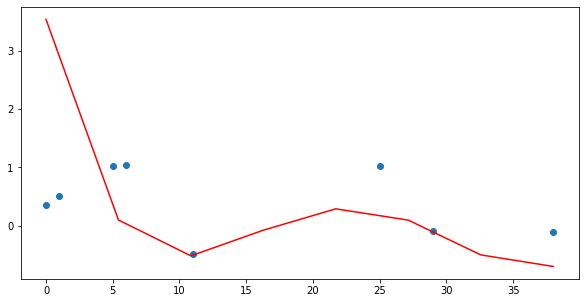

R^2 для степени 5
	валидация: 0.879
	обучающий набор: 0.898


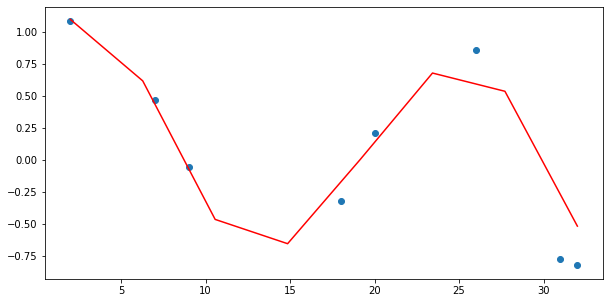

In [6]:
regression(noisysine.drop('y', axis=1), noisysine.y, 5, plot=True)

In [7]:
regression(hydrodynamics.drop('y', axis=1), hydrodynamics.y, 2)

R^2 для степени 1
	валидация: 0.590
	обучающий набор: 0.667
R^2 для степени 2
	валидация: 0.926
	обучающий набор: 0.929


# 2

In [8]:
def delta(r, b, x, t, s):
    xTxprt = x.T.dot(x) + r * t
    sqared = np.linalg.inv(xTxprt)
    inv_sqared = sqared.dot(sqared)
    return (r ** 2 * b.T).dot(inv_sqared).dot(b) + s * np.trace(x.dot(inv_sqared).dot(x.T))

def ridge(x, y, eps=0.00001, n_iter=1000, verbose=False):
    n = len(x)
    m = x.shape[1]
    t = np.eye(m, m)
    beta = lambda x, y, t: np.linalg.inv(x.T.dot(x) + r * t).dot(x.T).dot(y)

    errors = lambda x, y, b: y - x.dot(b)

    s2 = lambda errors, n, m: errors.T.dot(errors) / (n - m)

    r = 0
    i = 0
    while True:
        b = beta(x, y, t)
        
        e = errors(x, y, b)
        s = s2(e, n, m)
        r_old = r
        r = optimize.minimize(delta, [0.], args=(b, x, t, s)).x
        if verbose:
            print(f'Candidate r = {r}')
        i += 1
        if np.abs(r - r_old) <= eps or i == n_iter:
            break
    return r, b

Ridge = [83.18057917]
R^2 для степени 1
	валидация: -0.369
	обучающий набор: 0.063


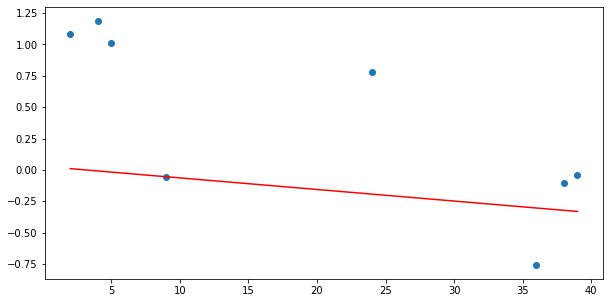

Ridge = [83.06910437]
R^2 для степени 2
	валидация: 0.034
	обучающий набор: 0.117


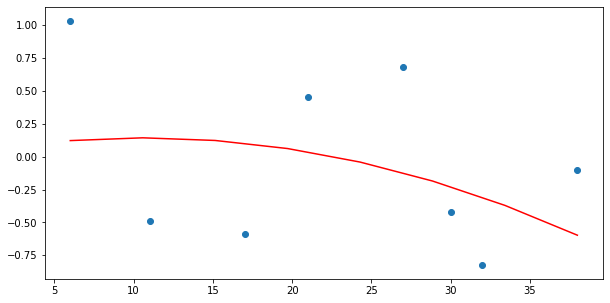

Ridge = [0.19946718]
R^2 для степени 3
	валидация: 0.025
	обучающий набор: 0.352


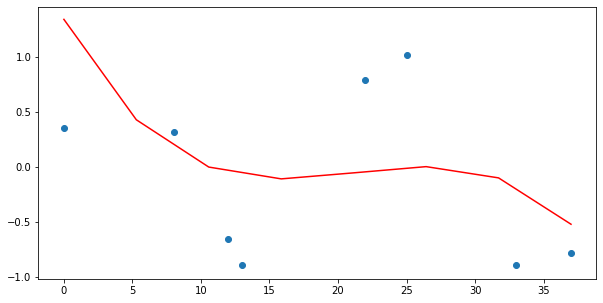

Ridge = [0.44666579]
R^2 для степени 4
	валидация: -4.550
	обучающий набор: 0.291


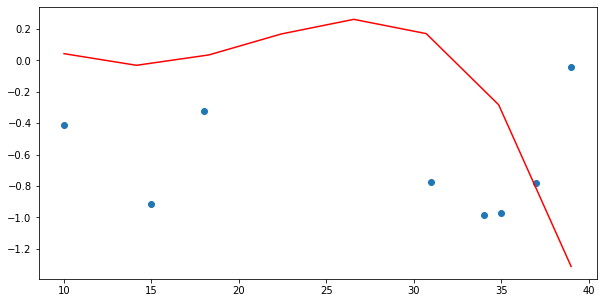

Ridge = [1.49825483]
R^2 для степени 5
	валидация: 0.920
	обучающий набор: 0.878


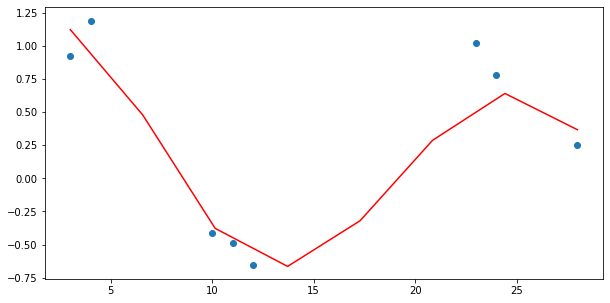

In [9]:
regression(noisysine.drop('y', axis=1), noisysine.y, 5, plot=True, b_ridge=True)

In [10]:
regression(hydrodynamics.drop('y', axis=1), hydrodynamics.y, 2, b_ridge=True)

Ridge = [0.17100696]
R^2 для степени 1
	валидация: 0.631
	обучающий набор: 0.637
Ridge = [0.00015377]
R^2 для степени 2
	валидация: 0.902
	обучающий набор: 0.933


# 3

Использовано признаков 0 / 2
R^2 для степени 1
	Весь набор: -0.000


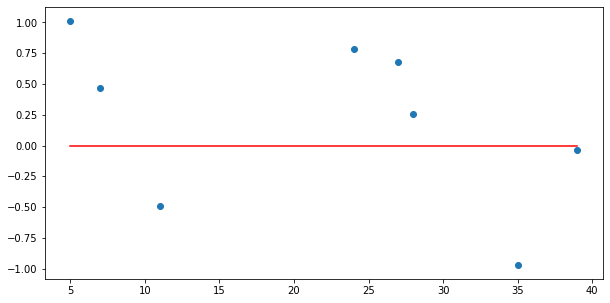

Использовано признаков 0 / 3
R^2 для степени 2
	Весь набор: -0.000


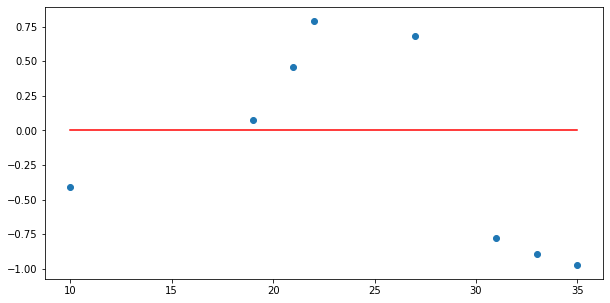

Использовано признаков 0 / 4
R^2 для степени 3
	Весь набор: -0.000


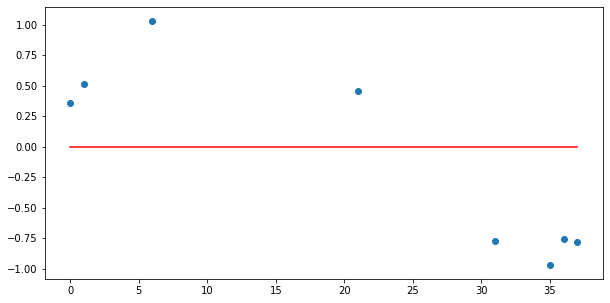

Использовано признаков 1 / 5
R^2 для степени 4
	Весь набор: 0.056


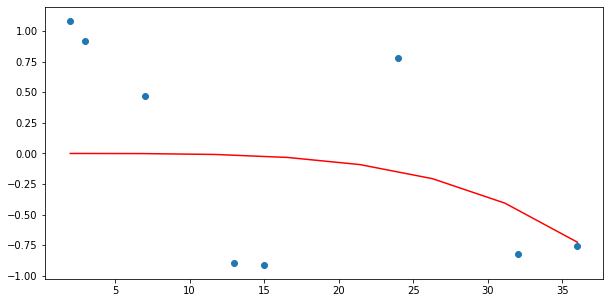

Использовано признаков 1 / 6
R^2 для степени 5
	Весь набор: 0.073


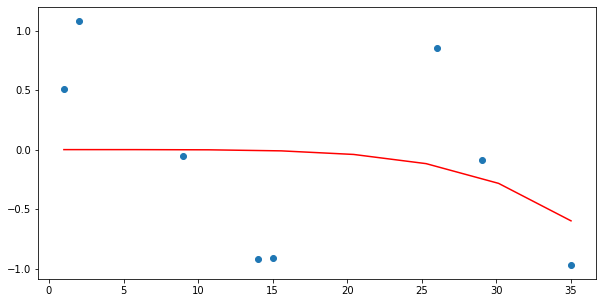

In [11]:
regression(noisysine.drop('y', axis=1), noisysine.y, 5, plot=True, lasso=True)

In [12]:
regression(hydrodynamics.drop('y', axis=1), hydrodynamics.y, 2, lasso=True)

Использовано признаков 6 / 7
R^2 для степени 1
	Весь набор: -1.255


C:\Users\ALEX\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92.37724803360106, tolerance: 5.81314421398374
  tol, rng, random, positive)
C:\Users\ALEX\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 136.37891955450687, tolerance: 5.81314421398374
  tol, rng, random, positive)
C:\Users\ALEX\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.440964373041425, tolerance: 5.81314421398374
  tol, rng, random, positive)
C:\Users\ALEX\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might wan

Использовано признаков 12 / 28
R^2 для степени 2
	Весь набор: 0.914


C:\Users\ALEX\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 282.609637231918, tolerance: 5.486792945731707
  tol, rng, random, positive)
C:\Users\ALEX\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 306.8524459624077, tolerance: 5.486792945731707
  tol, rng, random, positive)
C:\Users\ALEX\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 328.1452766666912, tolerance: 5.486792945731707
  tol, rng, random, positive)
C:\Users\ALEX\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might wan